# Quora Question Pairs

## Data overview

Data will be in a file questions.csv

questions.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate

Size of questions.csv - 60MB

Number of rows in questions.csv = 404,290

We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

### Example of Data point 

"id","qid1","qid2","question1","question2","is_duplicate"

"0","1","2","What is the step by step guide to invest in share market in india?","What is the
step by step guide to invest in share market?","0"

"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"

"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"

"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"

### Objective

For a given pair of questions, we have to predict the presence of duplicate questions

## Reading data and basic statistics

In [1]:
import os
os.chdir(r"C:\Users\Soham\Desktop")
os.getcwd()

'C:\\Users\\Soham\\Desktop'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import gc

import re
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [3]:
df = pd.read_csv("questions.csv")
print("Number of data points:",df.shape[0])

Number of data points: 404351


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
id              404351 non-null int64
qid1            404351 non-null int64
qid2            404351 non-null int64
question1       404350 non-null object
question2       404349 non-null object
is_duplicate    404351 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### Distribute data points among output classes

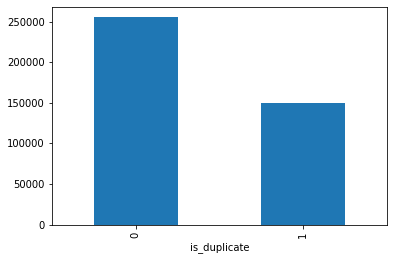

In [6]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [7]:
print('~> Total number of question pairs for training:\n {}'.format(len(df)))

~> Total number of question pairs for training:
 404351


In [8]:
print('~> Question pairs are not similar(is_duplicate = 0):\n {}%'.format(100-round(df['is_duplicate'].mean()*100,2)))
print('~> Question pairs are similar(is_duplicate = 1):\n {}%'.format(round(df['is_duplicate'].mean()*100,2)))

~> Question pairs are not similar(is_duplicate = 0):
 63.08%
~> Question pairs are similar(is_duplicate = 1):
 36.92%


### Find out number of unique questions

In [20]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len (np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of Unique Questions are: {}\n'.format(unique_qs))
print('Number of Repeated questions : {}({}%\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 
q_vals = qids.value_counts()
q_vals = q_vals.values


Total number of Unique Questions are: 789801

Number of Repeated questions : 13698(1.7343609339567814%

Max number of times a single question is repeated: 50



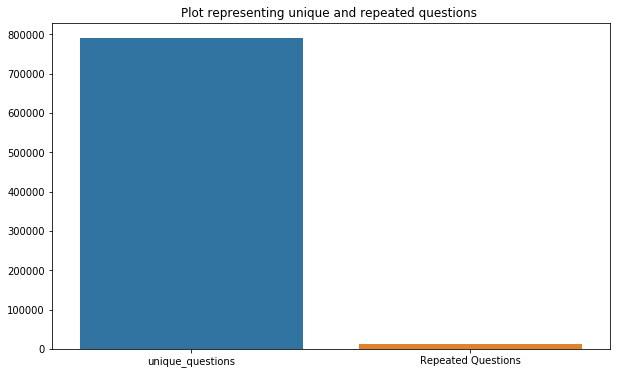

In [10]:
x = ["unique_questions" , "Repeated Questions"]
y = [unique_qs , qs_morethan_onetime]
plt.figure(figsize = (10,6))
plt.title("Plot representing unique and repeated questions ")
sns.barplot(x,y)
plt.show()

### Check out for duplicate questions

checking whether there are any repeated pair of questions

In [11]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions -3


### Determine the number of occurrences of each question

Maximum number of times a single question is repeated: 50



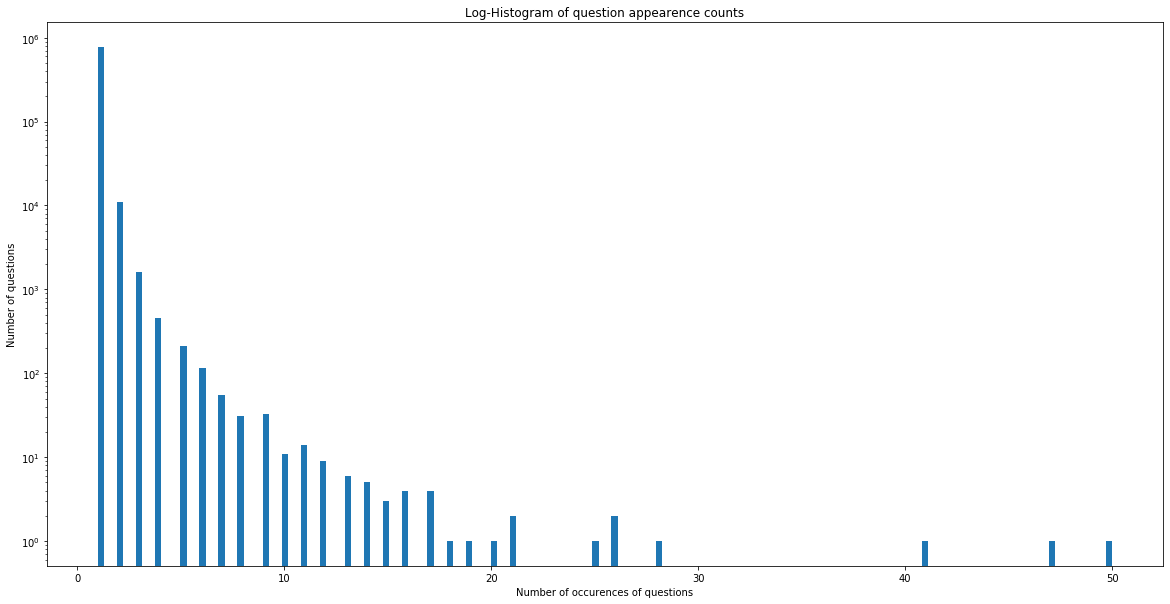

In [12]:
plt.figure(figsize = (20,10))
plt.hist(qids.value_counts(),bins = 160)
plt.yscale('log', nonposy = 'clip')
plt.title('Log-Histogram of question appearence counts')
plt.xlabel('Number of occurences of questions')
plt.ylabel('Number of questions')
print('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

### Check for null values

In [13]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105796  105796  209841  209842    How can I develop android app?   
201871  201871  398348  398349  How can I create an Android app?   
363416  363416  711434  711435                               NaN   

                                                question2  is_duplicate  
105796                                                NaN             0  
201871                                                NaN             0  
363416  My Chinese name is Haichao Yu. What English na...             0  


In [14]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


### Extract basic features

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [15]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding = 'latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    
    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)
    
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    
    df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid1']
    df['freq_q1-q2'] = df['freq_qid1'] - df['freq_qid1']
    
    df.to_csv("df_fe_without_preprocessing_train.csv",index = False)
    
df.head()   
    
    

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


### Analyze some of the extracted features

In [16]:
print("Minimum length of the questions in question1 :",min(df['q1_n_words']))

print("Minimum length of the questions in question2 :",min(df['q2_n_words']))

print("Number of Questions with minimum length ['question1']:" ,df[df['q1_n_words']==1].shape[0])

print("Number of Questions with minimum length ['question2']:" ,df[df['q2_n_words']==1].shape[0])

Minimum length of the questions in question1 : 1
Minimum length of the questions in question2 : 1
Number of Questions with minimum length ['question1']: 60
Number of Questions with minimum length ['question2']: 25


Feature: word_share

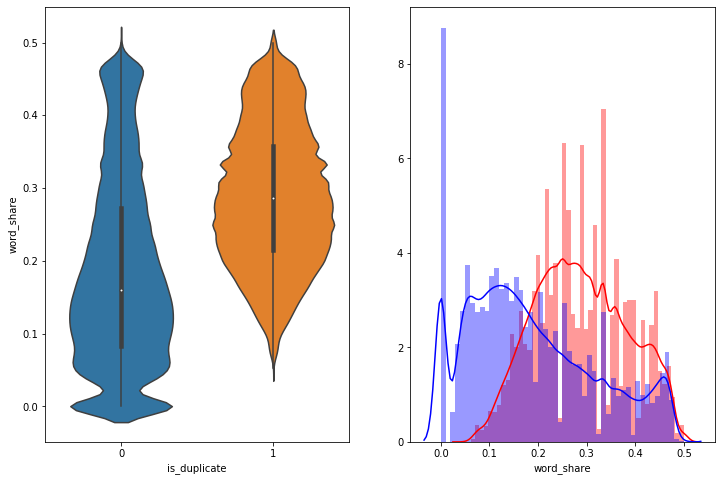

In [17]:
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share',data = df[0:])


plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

Feature: word_Common 

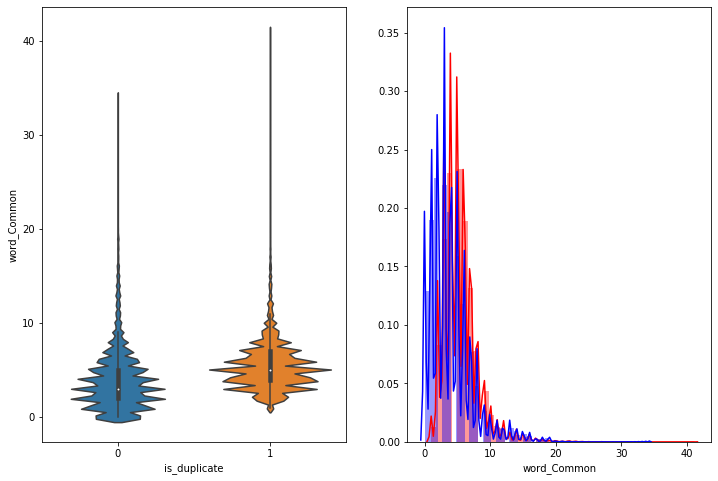

In [18]:
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common',data = df[0:])


plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>